## Neural Collaborative Filtering - NCF

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [70]:
dataset_df = pd.read_csv("../datasets/toy_dataset.csv")
dataset_df = dataset_df.melt(id_vars=['Unnamed: 0'], var_name='category', value_name='rating')
dataset_df.rename(columns={'Unnamed: 0': 'user_id'}, inplace=True)
dataset_df.rename(columns={'category': 'item_id'}, inplace=True)
dataset_df.fillna(0, inplace=True)

In [71]:
dataset_df["user_id"] = LabelEncoder().fit_transform(dataset_df["user_id"])
dataset_df["item_id"] = LabelEncoder().fit_transform(dataset_df["item_id"])
dataset_df["rating"] = MinMaxScaler().fit_transform(dataset_df["rating"].to_numpy().reshape(-1, 1))

In [72]:
dataset

,user_id,item_id,rating
0,0,0,0.8
1,1,0,1.0
2,2,0,0.2
3,3,0,0.0
4,4,0,0.2
5,0,1,1.0
6,1,1,0.6
7,2,1,0.0
8,3,1,0.4
9,4,1,0.0


In [73]:
np_dataset = dataset.to_numpy()
np_dataset

array([[0. , 0. , 0.8],
       [1. , 0. , 1. ],
       [2. , 0. , 0.2],
       [3. , 0. , 0. ],
       [4. , 0. , 0.2],
       [0. , 1. , 1. ],
       [1. , 1. , 0.6],
       [2. , 1. , 0. ],
       [3. , 1. , 0.4],
       [4. , 1. , 0. ],
       [0. , 2. , 0.6],
       [1. , 2. , 0.6],
       [2. , 2. , 0. ],
       [3. , 2. , 0.2],
       [4. , 2. , 0.4],
       [0. , 3. , 0. ],
       [1. , 3. , 0.4],
       [2. , 3. , 0.8],
       [3. , 3. , 0.8],
       [4. , 3. , 0.6],
       [0. , 4. , 0.4],
       [1. , 4. , 0.4],
       [2. , 4. , 1. ],
       [3. , 4. , 0. ],
       [4. , 4. , 0.6],
       [0. , 5. , 0.2],
       [1. , 5. , 0. ],
       [2. , 5. , 0.8],
       [3. , 5. , 0.6],
       [4. , 5. , 0.8]])

In [144]:
X, y = torch.tensor(np_dataset[:, :-1]).type(torch.LongTensor), torch.tensor(np_dataset[:, -1]).unsqueeze(1).type(torch.float32)

In [145]:
dataset = TensorDataset(X, y)

In [146]:
dataset[:3]

(tensor([[0, 0],
         [1, 0],
         [2, 0]]),
 tensor([[0.8000],
         [1.0000],
         [0.2000]]))

In [304]:
loader = DataLoader(dataset, batch_size=10, shuffle=True)

In [305]:
next(iter(loader))

[tensor([[4, 0],
         [3, 5],
         [4, 2],
         [2, 0],
         [3, 0],
         [4, 1],
         [1, 2],
         [2, 3],
         [3, 3],
         [4, 5]]),
 tensor([[0.2000],
         [0.6000],
         [0.4000],
         [0.2000],
         [0.0000],
         [0.0000],
         [0.6000],
         [0.8000],
         [0.8000],
         [0.8000]])]

### 02. Model Building: 

In [306]:
class GMFBlock(nn.Module):

    def __init__(
        self,
        num_users: int, 
        num_items: int,
        latent_dim: int
    ) -> None:
        super(GMFBlock, self).__init__()

        self.users_embs = nn.Embedding(
            num_embeddings= num_users,
            embedding_dim= latent_dim
        )

        self.items_embs = nn.Embedding(
            num_embeddings= num_items,
            embedding_dim= latent_dim
        )

        self.edge_weight = nn.Linear(
            in_features= latent_dim,
            out_features= 1
        ) 

    def forward(
        self,
        userIds: torch.LongTensor,
        itemsIds: torch.LongTensor
    ) -> torch.Tensor:

        user_embs = self.users_embs(userIds)
        items_embs = self.users_embs(itemsIds)

        logits = self.edge_weight(
            torch.mul(user_embs, items_embs)
        )
        return F.sigmoid(logits)

In [360]:
model = GMFBlock(
    num_users=5,
    num_items=6,
    latent_dim=2
)

In [361]:
model

GMFBlock(
  (users_embs): Embedding(5, 2)
  (items_embs): Embedding(6, 2)
  (edge_weight): Linear(in_features=2, out_features=1, bias=True)
)

In [362]:
inputs, targets = next(iter(loader))

In [363]:
inputs

tensor([[4, 2],
        [2, 2],
        [4, 3],
        [3, 0],
        [0, 1],
        [2, 1],
        [0, 4],
        [3, 5],
        [1, 5],
        [3, 2]])

In [364]:
usersIds, itemsIds = inputs[:, 0], inputs[:, 0]

In [365]:
model(usersIds, itemsIds)

tensor([[0.6544],
        [0.5982],
        [0.6544],
        [0.6121],
        [0.5993],
        [0.5982],
        [0.5993],
        [0.6121],
        [0.6622],
        [0.6121]], grad_fn=<SigmoidBackward0>)

In [366]:
crit = nn.BCELoss()

In [416]:
opt = torch.optim.AdamW(model.parameters(), lr=0.9)

In [420]:
for epoch in range(1000):

    total_loss = 0

    # for inputs, targets in loader:

    inputs, targets = dataset[:]
    
    opt.zero_grad()
    
    usersIds, itemsIds = inputs[:, 0], inputs[:, 0]

    out = model(usersIds, itemsIds)

    loss = crit(out, targets)

    total_loss += loss.item()

    loss.backward()

    opt.step()

    if epoch % 100 == 0: print("Loss : ", total_loss)

Loss :  0.679834246635437
Loss :  0.6795942783355713
Loss :  0.6795939803123474
Loss :  0.679694414138794
Loss :  0.6801851987838745
Loss :  0.679700493812561
Loss :  0.6796716451644897
Loss :  0.6801233291625977
Loss :  0.6795939207077026
Loss :  0.6802371144294739


In [418]:
model.edge_weight.weight.grad

tensor([[0.1286, 0.0448]])

In [405]:
user_weight = model.users_embs.weight.detach().numpy()

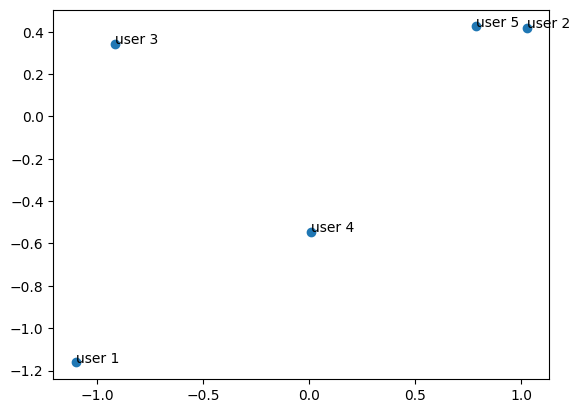

In [406]:
plt.scatter(x=user_weight[:, 0], y=user_weight[:, 1])
for i, label in enumerate([f"user {index}" for index in range(1, 6)]):
    plt.annotate(label, (user_weight[i, 0], user_weight[i, 1]))